# What does a neural network learn?

### Setting up

**Notebook setup**. Select the "Edit" menu, then "Notebook settings". Choose "GPU" as the hardware accelerator. Check that "Omit code cell output..." is unchecked (so that the output is saved).

**Upload dataset** Select the folder icon from the left sidebar menu. Click the upload button and select the file "lab6data.zip" from your computer.

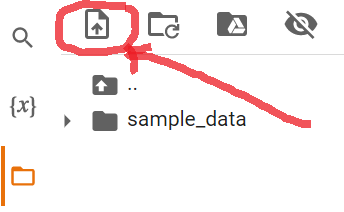

### Extract the dataset

In [1]:
!unzip lab6data.zip

Archive:  lab6data.zip
   creating: lab6/
   creating: lab6/test/
   creating: lab6/test/Cat/
  inflating: lab6/test/Cat/10045.jpg  
  inflating: lab6/test/Cat/10076.jpg  
  inflating: lab6/test/Cat/10150.jpg  
  inflating: lab6/test/Cat/10310.jpg  
  inflating: lab6/test/Cat/10347.jpg  
  inflating: lab6/test/Cat/10671.jpg  
  inflating: lab6/test/Cat/10691.jpg  
  inflating: lab6/test/Cat/10877.jpg  
  inflating: lab6/test/Cat/10895.jpg  
  inflating: lab6/test/Cat/1117.jpg  
  inflating: lab6/test/Cat/11281.jpg  
  inflating: lab6/test/Cat/11397.jpg  
  inflating: lab6/test/Cat/11412.jpg  
  inflating: lab6/test/Cat/11427.jpg  
  inflating: lab6/test/Cat/11515.jpg  
  inflating: lab6/test/Cat/11517.jpg  
  inflating: lab6/test/Cat/11559.jpg  
  inflating: lab6/test/Cat/11583.jpg  
  inflating: lab6/test/Cat/11610.jpg  
  inflating: lab6/test/Cat/11713.jpg  
  inflating: lab6/test/Cat/12165.jpg  
  inflating: lab6/test/Cat/12210.jpg  
  inflating: lab6/test/Cat/12268.jpg  
  inflatin

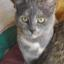

In [2]:
from PIL import Image
im = Image.open("lab6/train/Cat/161.jpg")
display(im)

### Import PyTorch

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

### Prepare the dataset for PyTorch


In [4]:
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [5]:
train_ds = datasets.ImageFolder('lab6/train', transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [6]:
test_ds = datasets.ImageFolder('lab6/test', transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
print(f'Number of classes: {len(train_ds.classes)}')
print(f'Class names: {train_ds.classes}')
print(f'Number of images: {len(train_ds)}')
print(f'Number of images: {len(test_ds)}')

Number of classes: 2
Class names: ['Cat', 'Dog']
Number of images: 1800
Number of images: 200


### Experiment 1: train a model from scratch

Follow the instructions in moodle. You can start adding code in cells below and running them by pressing the forward arrow button in the corner. Add more cells as needed.

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.cnn_stack(x)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
model = CNN().to(device)



def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  {current:>5d}/{size:>5d}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 0.702008     32/ 1800
loss: 0.697621    352/ 1800
loss: 0.692796    672/ 1800
loss: 0.687026    992/ 1800
loss: 0.699233   1312/ 1800
loss: 0.700588   1632/ 1800
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.696819 

Epoch 2
-------------------------------
loss: 0.706658     32/ 1800
loss: 0.694772    352/ 1800
loss: 0.694269    672/ 1800
loss: 0.698861    992/ 1800
loss: 0.677502   1312/ 1800
loss: 0.657046   1632/ 1800
Test Error: 
 Accuracy: 57.5%, Avg loss: 0.704173 

Epoch 3
-------------------------------
loss: 0.721194     32/ 1800
loss: 0.649657    352/ 1800
loss: 0.665050    672/ 1800
loss: 0.685427    992/ 1800
loss: 0.738050   1312/ 1800
loss: 0.655520   1632/ 1800
Test Error: 
 Accuracy: 54.0%, Avg loss: 0.678232 

Epoch 4
-------------------------------
loss: 0.687063     32/ 1800
loss: 0.727923    352/ 1800
loss: 0.612203    672/ 1800
loss: 0.717991    992/ 1800
loss: 0.670960   1312/ 1800
loss: 0.636260   1632/

In [ ]:
 Accuracy: 73.0%, Avg loss: 1.015260 for epoch 15 Using cuda device, The model starts with random initialization (accuracy ~50%, equivalent to guessing)
The final test accuracy of 73% is modest but expected given:
Small dataset (only 1800 training samples)
"Poor quality" dataset as mentioned in the description

Q1: What was the result (average accuracy of classifying cats and dogs in experiment 1)? Explain or comment the result. [TYPE YOUR ANSWER HERE]

### Experiment 2: side channel data

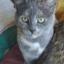

Epoch 1
-------------------------------
loss: 0.690172     32/ 1800
loss: 0.554066    352/ 1800
loss: 0.262383    672/ 1800
loss: 0.235609    992/ 1800
loss: 0.257454   1312/ 1800
loss: 0.147228   1632/ 1800
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.332756 

Epoch 2
-------------------------------
loss: 0.133610     32/ 1800
loss: 0.196028    352/ 1800
loss: 0.221173    672/ 1800
loss: 0.339013    992/ 1800
loss: 0.251755   1312/ 1800
loss: 0.253789   1632/ 1800
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.383810 

Epoch 3
-------------------------------
loss: 0.164249     32/ 1800
loss: 0.261349    352/ 1800
loss: 0.115840    672/ 1800
loss: 0.143984    992/ 1800
loss: 0.216493   1312/ 1800
loss: 0.360690   1632/ 1800
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.246816 

Epoch 4
-------------------------------
loss: 0.189764     32/ 1800
loss: 0.119131    352/ 1800
loss: 0.185588    672/ 1800
loss: 0.087857    992/ 1800
loss: 0.143697   1312/ 1800
loss: 0.075501   1632/ 1800
Test Error: 

In [13]:
!mkdir -p lab6/train2/Cat lab6/train2/Dog lab6/test2/Cat lab6/test2/Dog
import os
import os.path

RED_TINT = [1.1, 0, 0, 0,
           0, 1, 0, 0,
           0, 0, 0.9, 0]
BLUE_TINT = [0.9, 0, 0, 0,
           0, 1, 0, 0,
           0, 0, 1.1, 0]
def tone_images(ipath, opath, matrix):
    files = os.listdir(ipath)
    for fn in files:
        src = os.path.join(ipath, os.path.basename(fn))
        dest = os.path.join(opath, os.path.basename(fn))
        im = Image.open(src)
        im.convert("RGB", matrix).save(dest)

tone_images("lab6/train/Cat", "lab6/train2/Cat", BLUE_TINT)
tone_images("lab6/train/Dog", "lab6/train2/Dog", RED_TINT)
tone_images("lab6/test/Cat", "lab6/test2/Cat", BLUE_TINT)
tone_images("lab6/test/Dog", "lab6/test2/Dog", RED_TINT)

im = Image.open("lab6/train2/Cat/161.jpg")
display(im)

train_ds2 = datasets.ImageFolder('lab6/train2', transform=transform)
test_ds2 = datasets.ImageFolder('lab6/test2', transform=transform)

train_dataloader2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
test_dataloader2 = DataLoader(test_ds2, batch_size=batch_size, shuffle=False)

model2 = CNN().to(device)
optimizer2 = optim.Adam(model2.parameters())
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader2, model2, loss_fn, optimizer2)
    test(test_dataloader2, model2, loss_fn)
print("Done!")

In [ ]:
 Accuracy: 91.0%, Avg loss: 0.423586 on epoch 15 but some earlier epochs had  92.5% aswell
 The model reaches high accuracy much earlier (already 89.5% in Epoch 1)
 Instead of learning meaningful features ( cat ears, dog ears), the model likely learns to classify based on color dominance.

Q2: What was the result after altering the color balance of images? Explain or comment the result. [YOUR ANSWER]

### Experiment 3: adversarial data

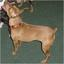

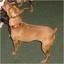

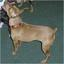

Test Error: 
 Accuracy: 10.0%, Avg loss: 8.534767 



In [14]:
!mkdir -p lab6/test3/Cat lab6/test3/Dog
tone_images("lab6/test/Cat", "lab6/test3/Cat", RED_TINT)
tone_images("lab6/test/Dog", "lab6/test3/Dog", BLUE_TINT)

display(Image.open("lab6/test/Dog/10010.jpg"))
display(Image.open("lab6/test2/Dog/10010.jpg"))
display(Image.open("lab6/test3/Dog/10010.jpg"))

test_ds3 = datasets.ImageFolder('lab6/test3', transform=transform)
test_dataloader3 = DataLoader(test_ds3, batch_size=batch_size, shuffle=False)
test(test_dataloader3, model2, loss_fn)

In [ ]:
Test Error:
 Accuracy: 10.0%, Avg loss: 8.534767
 Accuracy drops catastrophically (near random guessing for binary classification).

Test loss skyrockets (compared to ~0.2–0.4 in Experiment 2).

The Model Relied Entirely on Color Bias

In Experiment 2, the model was trained on:

Cats → Blue tint

Dogs → Red tint

It never learned meaningful features (e.g., shapes, textures) and instead memorized the color cue.

Q3: What was the result after using a different color alteration in test images? Explain or comment the result.

### Experiment 4: transfer learning

In [15]:
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in base_model.parameters():
    param.requires_grad = False

class PretrainedModel(nn.Module):
    def __init__(self, base_model):
        super(PretrainedModel, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_model.fc.in_features, 2)

    def forward(self, x):
        x = self.base_model(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model4 = PretrainedModel(base_model).to(device)

transform4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds4 = datasets.ImageFolder('lab6/train2', transform=transform4)
test_ds4 = datasets.ImageFolder('lab6/test3', transform=transform4)

train_dataloader4 = DataLoader(train_ds4, batch_size=batch_size, shuffle=True)
test_dataloader4 = DataLoader(test_ds4, batch_size=batch_size, shuffle=False)

optimizer4 = optim.Adam(model4.parameters())

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader4, model4, loss_fn, optimizer4)
    print("\n")
print("Done!")

print("Training data:")
test(train_dataloader4, model4, loss_fn)
print("Adversarial data:")
test(test_dataloader4, model4, loss_fn)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.3MB/s]


Epoch 1
-------------------------------
loss: 0.665647     32/ 1800
loss: 0.292631    352/ 1800
loss: 0.178835    672/ 1800
loss: 0.298459    992/ 1800
loss: 0.184928   1312/ 1800
loss: 0.253930   1632/ 1800


Epoch 2
-------------------------------
loss: 0.134732     32/ 1800
loss: 0.163085    352/ 1800
loss: 0.065712    672/ 1800
loss: 0.072059    992/ 1800
loss: 0.126516   1312/ 1800
loss: 0.158957   1632/ 1800


Epoch 3
-------------------------------
loss: 0.281102     32/ 1800
loss: 0.135190    352/ 1800
loss: 0.120143    672/ 1800
loss: 0.107019    992/ 1800
loss: 0.474745   1312/ 1800
loss: 0.092994   1632/ 1800


Epoch 4
-------------------------------
loss: 0.082561     32/ 1800
loss: 0.130362    352/ 1800
loss: 0.153631    672/ 1800
loss: 0.060759    992/ 1800
loss: 0.100039   1312/ 1800
loss: 0.139111   1632/ 1800


Epoch 5
-------------------------------
loss: 0.090108     32/ 1800
loss: 0.034158    352/ 1800
loss: 0.224433    672/ 1800
loss: 0.074583    992/ 1800
loss: 0.

In [ ]:
Training data:
Test Error:
 Accuracy: 98.3%, Avg loss: 0.056505
 The model learned the training set extremely well, including the artificial blue=cat, red=dog bias.

 Unlike the simple CNN (Experiment 3), which relied entirely on color, ResNet50 already knows general object shapes from ImageNet.

Even though the final classifier layer was trained on biased data, the underlying features still capture cat/dog structures.


Why is Training Accuracy So High (98.3%)?
The model memorized the training set, including the color shortcut.

Since the training data was artificially biased, achieving near-perfect accuracy was easy.




Adversarial data:
Test Error:
 Accuracy: 54.0%, Avg loss: 1.111171
 Just slightly better than random guessing in binary classification
 The model struggles but doesn’t completely fail like the CNN from scratch (which dropped to 10%).
 The last fully connected (FC) layer was trained on tinted images, so it partially relies on color cues.

When colors are flipped, this introduces confusion, reducing accuracy.



Q4: The ResNet50 based model was trained and tested just like in experiment 3. What happened? Explain or comment the result. [YOUR ANSWER]